In [28]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langchain_community.tools import TavilySearchResults
from typing import TypedDict, Annotated,List
from langchain_core.messages import BaseMessage
from langgraph.graph import add_messages, StateGraph, END
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from pydantic import BaseModel
from langchain_groq import ChatGroq

In [2]:
load_dotenv()

True

In [9]:
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]

In [10]:
search_tool=TavilySearchResults(max_results=5)

In [11]:
tools=[search_tool]

In [29]:
llmLlama=ChatGroq(model="llama-3.1-8b-instant")

In [30]:
llm_with_tools=llmLlama.bind_tools(tools=tools)

In [31]:
def model(state: AgentState):
    state["messages"]=[llm_with_tools.invoke(input=state["messages"])]
    return state
    

In [32]:
def tools_router(state:AgentState):
    last_message=state["messages"][-1]

    if hasattr(last_message,"tool_calls") and len(last_message.tool_calls)>0:
        return "tool_node"
    else:
        return "end"

In [33]:
tool_node=ToolNode(tools=tools,messages_key="messages")

In [34]:
graph=StateGraph(state_schema=AgentState)

In [35]:
graph.add_node(node="model",action=model)

In [36]:
graph.add_node(node="tool_node",action=tool_node)

In [37]:
graph.set_entry_point(key="model")

In [38]:
graph.add_conditional_edges(source="model",path=tools_router,path_map={"tool_node":"tool_node","end":END})

In [39]:
graph.add_edge(start_key="tool_node",end_key="model")

In [40]:
app=graph.compile()

In [41]:
print(app.get_graph().draw_ascii())

          +-----------+           
          | __start__ |           
          +-----------+           
                 *                
                 *                
                 *                
            +-------+             
            | model |             
            +-------+.            
           ..         ..          
         ..             ..        
        .                 .       
+-----------+         +---------+ 
| tool_node |         | __end__ | 
+-----------+         +---------+ 


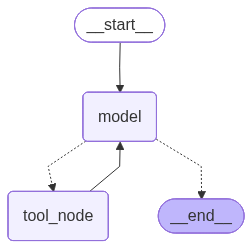

In [42]:
display(Image(data=app.get_graph(xray=True).draw_mermaid_png()))

In [43]:
input={
    "messages":["What's the current weather in Bangalore?"]
}

In [44]:
app.invoke(input=input)

{'messages': [HumanMessage(content="What's the current weather in Bangalore?", additional_kwargs={}, response_metadata={}, id='387bbf81-9ae2-409d-a5e7-f7b3046c9a7b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '03df25s95', 'function': {'arguments': '{"query":"Bangalore current weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 286, 'total_tokens': 307, 'completion_time': 0.042040609, 'prompt_time': 0.063100039, 'queue_time': 0.09067843, 'total_time': 0.105140648}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--3aec7bad-1f44-40da-9384-8e6156a4227d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Bangalore current weather'}, 'id': '03df25s95', 'type': 'tool_call'}], usage_metadata={'input_tokens': 286, 'output_tokens': 21, 'total_tokens': 307}),
  ToolMess

In [45]:
events=app.stream(input=input, stream_mode="values")

In [46]:
for event in events:
    print(event,"\n")

{'messages': [HumanMessage(content="What's the current weather in Bangalore?", additional_kwargs={}, response_metadata={}, id='b237e91c-52f0-41cc-b6f5-d4ad76f29eef')]} 

{'messages': [HumanMessage(content="What's the current weather in Bangalore?", additional_kwargs={}, response_metadata={}, id='b237e91c-52f0-41cc-b6f5-d4ad76f29eef'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'dkanrf8gz', 'function': {'arguments': '{"query":"Bangalore current weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 286, 'total_tokens': 307, 'completion_time': 0.033511762, 'prompt_time': 0.016171097, 'queue_time': 0.055240153, 'total_time': 0.049682859}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--abc93bfc-d4e9-44f2-9a9c-d092bcd3c4be-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'qu

In [47]:
events=app.stream(input=input, stream_mode="updates")

In [48]:
for event in events:
    print(event,"\n")

{'model': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'm0azv4zt0', 'function': {'arguments': '{"query":"Bangalore current weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 286, 'total_tokens': 307, 'completion_time': 0.034887668, 'prompt_time': 0.016035507, 'queue_time': 0.054686273, 'total_time': 0.050923175}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--94dad35b-a796-4e96-b374-85c4dd799367-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Bangalore current weather'}, 'id': 'm0azv4zt0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 286, 'output_tokens': 21, 'total_tokens': 307})]}} 

{'tool_node': {'messages': [ToolMessage(content='[{"title": "Bangalore, India: 1 hour detailed weather forecast for 2026-01-07", "url": "https://weath

In [49]:
input={
    "messages":["Which WWE Superstar passed away recently?"]
}

In [50]:
events=app.astream_events(input=input, version="v2")

In [51]:
async for event in events:
    print(event,"\n")

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Which WWE Superstar passed away recently?']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '804d2288-9c9f-4e40-83ba-7fb4c80ba5d7', 'metadata': {}, 'parent_ids': []} 

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Which WWE Superstar passed away recently?', additional_kwargs={}, response_metadata={}, id='2c2993c3-01b2-4a1d-9464-9602b162d6f0')]}}, 'name': 'model', 'tags': ['graph:step:1'], 'run_id': '2f3e8ec7-65ba-4323-b814-e557039419ba', 'metadata': {'langgraph_step': 1, 'langgraph_node': 'model', 'langgraph_triggers': ('branch:to:model',), 'langgraph_path': ('__pregel_pull', 'model'), 'langgraph_checkpoint_ns': 'model:f0d1b866-b54d-a353-f260-34770c488182'}, 'parent_ids': ['804d2288-9c9f-4e40-83ba-7fb4c80ba5d7']} 

{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Which WWE Superstar passed away recently?', additional_kwargs={}, response_metadata={}, id='

In [53]:
events=app.astream_events(input=input, version="v2")

In [54]:
async for event in events:
    if event["event"]=="on_chat_model_stream":
        print(event['data']['chunk'].content,end="",flush=True)

Based on the search results, it appears that Hulk Hogan is not the WWE Superstar who passed away recently. Hulk Hogan passed away on July 24, 2023, at the age of 71, due to a heart attack.

The search results do not provide a clear answer to the question, but they do mention several WWE Superstars who passed away in 2023, including Jay Briscoe, who died on January 17, 2023, at the age of 38, due to a car crash.

To answer the question, I would recommend checking the latest news and updates on WWE Superstars who have passed away.